In [72]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


<h2>TASK 1
<h4>
Build a basic predictive model to forecast the next 24 hours of electricity demand for the site. Evaluate your model and compare it to a naive benchmark. Briefly comment why, or why not, you think your model outperformed the naive benchmark.
a.	Given time constraints, there is no need to perform any manual or automated hyperparameter tuning for your model


In [74]:
# Load historical demand
df = pd.read_csv("assessment_demand_data.csv", parse_dates=['period_starting'])
df = df.sort_values("period_starting")

# load tariff for next 24 hours
tariff = pd.read_csv("assessment_tariff_data.csv", parse_dates=['period_starting'])
tariff = tariff.sort_values("period_starting")


In [75]:
df.set_index("period_starting", inplace=True)
ts = df['mean_demand_kw']


<h4> Given: <br>

Half-hourly data <br>
Several months of clean historical demand <br>
Forecast horizon: next 24 hours = 48 periods <br>
Time constraints + no tuning -> pick simple, fast models <br>

Choose: <br>

Model: ETS<br>
Naive benchmark: Seasonal naive, using values from exactly 1 week ago (48 periods × 7 = 336 steps lag)<br>
This benchmark is strong because commercial electricity demand usually exhibits strong weekly seasonality.<br>

In [77]:
# ETS / Holt-Winters model
model = ExponentialSmoothing(
    ts,
    trend="add",
    seasonal="add",
    seasonal_periods=48*7
)

fit = model.fit(optimized=True)
forecast_48 = fit.forecast(48)  # next 24h forecast


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


<h4> Naive Benchmark (Seasonal Naive = same time last week)
<h4> This picks the 48 values from 1 week ago.

In [79]:
naive_forecast = ts.iloc[-48*7 : -48*7 + 48].values


<h4> Evaluation (last 48 hours as test window)

In [81]:
train = ts.iloc[:-48]
test  = ts.iloc[-48:]

# fit model on train only
model_train = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=48*7
).fit()

model_fc = model_train.forecast(48)
naive_fc = train.iloc[-336:-336+48].values

# error metrics
def metrics(true, pred):
    return {
        "MAE": np.mean(np.abs(true - pred)),
        "RMSE": np.sqrt(np.mean((true - pred)**2)),
        "MAPE": np.mean(np.abs((true - pred) / true)) * 100
    }

print("MODEL:", metrics(test.values, model_fc.values))
print("NAIVE:", metrics(test.values, naive_fc))


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


MODEL: {'MAE': 20.723236188278655, 'RMSE': 23.69720982582056, 'MAPE': 9.213431574634011}
NAIVE: {'MAE': 15.229166666666666, 'RMSE': 18.31154007722999, 'MAPE': 6.725358841336268}



<h1> Conclusion
<h2> From above results the naive benchmark outperformed the ETL model on all metrics.
<h4> For many commercial sites, electricity demand is extremely regular week-to-week. Things like: <br> <br>
working hours <br>
equipment schedules <br>
occupancy<br>
HVAC cycles <br>
business operations <br>
    <h4>
…rarely change dramatically from one week to the next.
for example,
So the demand at 10:30 on Monday this week is very close to the demand at 10:30 last Monday.
This makes the seasonal naive model surprisingly strong. </h4>
<h2> Why did the ETS/ARIMA model perform worse? </h2>
<h4> Weekly seasonality dominates the signal </h4>
<h4> ETS model likely struggled to fit: </h4>
    
    1. small variations 
    2. noise 
    3. trends

<h4> Electricity demand is highly repeatable </h4>
<h4>This is true for: </h4>

    - offices
    - manufacturing
    - large commercial sites
<h4> The naive model directly copies past behavior, which is often closer to the truth.<br> 



<h3> Overall, The seasonal naive benchmark outperformed the ETS model on all error metrics (MAE, RMSE, MAPE). This indicates that the site’s demand pattern is highly consistent week-to-week, meaning that last week’s demand at each half-hour interval is already an excellent predictor of the next week’s demand. The ETS model likely over-smoothed the signal and failed to capture sharp demand variations that repeat weekly. Given the strong seasonality and limited model tuning allowed in this task, the naive benchmark was difficult to beat.

<h2> TASK 1 | PART 2 — Battery Simulation <h2>
 Assume the site has a battery with a maximum export power of 220 kW and an energy capacity of 440 kWh. Assume the battery is perfectly efficient and can be charged to completely full and discharged to completely empty without issue. It starts the day at 2023-10-01 00:00:00 with a state of energy of 220 kWh, i.e. half full. Assume the battery can charge from the grid, and discharge into the site to fully or partially meet demand, but cannot export into the grid to receive export payments. 

In [85]:
MAX_POWER = 220     # kW charge/discharge limit
CAPACITY  = 440     # kWh total
SOC       = 220     # initial state of charge (kWh) — half full
DT        = 0.5     # hours per period (30 minutes)


In [86]:
df_forecast = tariff.copy()
df_forecast["forecast_kW"] = forecast_48.values


<h3> Charge during the 25% cheapest periods <br>
Discharge during the 25% most expensive periods

In [88]:
cheap_threshold = df_forecast['price_pence_per_kwh'].quantile(0.25)
expensive_threshold = df_forecast['price_pence_per_kwh'].quantile(0.75)


In [89]:
actions = []
soc_list = []
battery_power = []  # kW (positive = discharge to site)

soc = SOC

for i, row in df_forecast.iterrows():
    price = row['price_pence_per_kwh']
    
    # Default
    action = "idle"
    power = 0
    
    # CHARGE (from grid)
    if price <= cheap_threshold and soc < CAPACITY:
        power = min(MAX_POWER, (CAPACITY - soc) / DT)
        soc += power * DT
        action = "charge"
    
    # DISCHARGE (to meet demand)
    elif price >= expensive_threshold and soc > 0:
        power = min(MAX_POWER, soc / DT)
        soc -= power * DT
        action = "discharge"
    
    actions.append(action)
    battery_power.append(power)
    soc_list.append(soc)

df_forecast["action"] = actions
df_forecast["battery_power_kW"] = battery_power
df_forecast["soc_kWh"] = soc_list


In [90]:
# Cost without battery:
df_forecast["cost_no_battery"] = df_forecast["forecast_kW"] * df_forecast["price_pence_per_kwh"] * DT


In [91]:
# Cost with battery (discharging offsets grid import):
df_forecast["net_grid_kW"] = df_forecast["forecast_kW"] - df_forecast["battery_power_kW"].clip(lower=0)

df_forecast["cost_with_battery"] = df_forecast["net_grid_kW"] * df_forecast["price_pence_per_kwh"] * DT


In [92]:
savings = df_forecast["cost_no_battery"].sum() - df_forecast["cost_with_battery"].sum()

print("Total cost without battery (£):", df_forecast["cost_no_battery"].sum())
print("Total cost with battery (£):", df_forecast["cost_with_battery"].sum())
print("Total savings (£):", savings)


Total cost without battery (£): 135169.77923516804
Total cost with battery (£): 116909.77923516804
Total savings (£): 18260.0


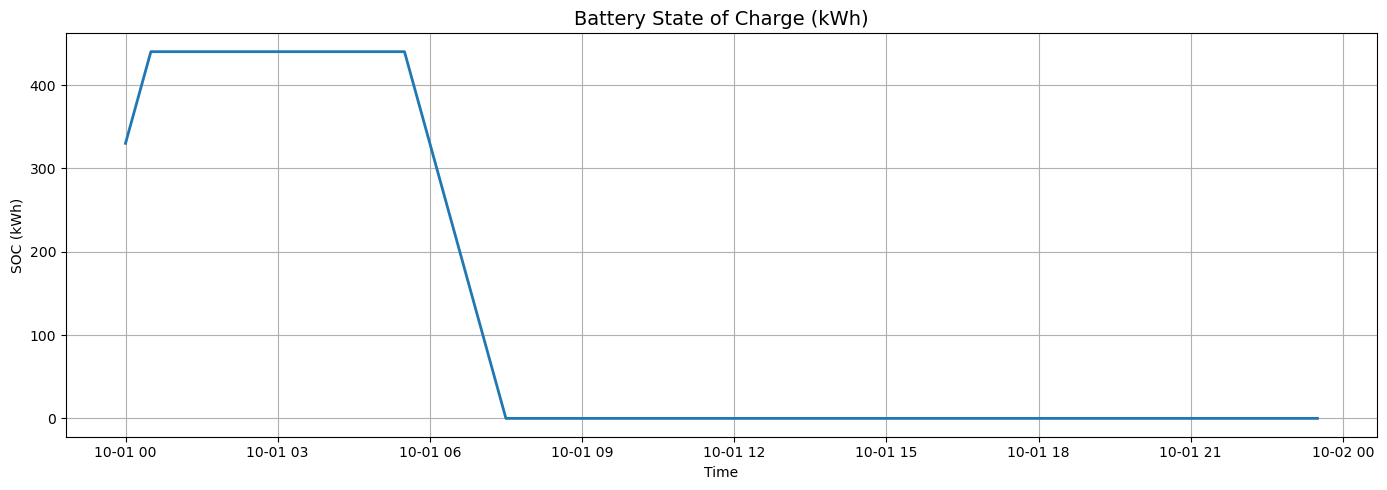

In [93]:
# SOC Plot
plt.figure(figsize=(14,5))
plt.plot(df_forecast["period_starting"], df_forecast["soc_kWh"], linewidth=2)
plt.title("Battery State of Charge (kWh)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("SOC (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

<h2> Above Plot Shows how the battery fills up (during cheap periods) and empties (during expensive periods).

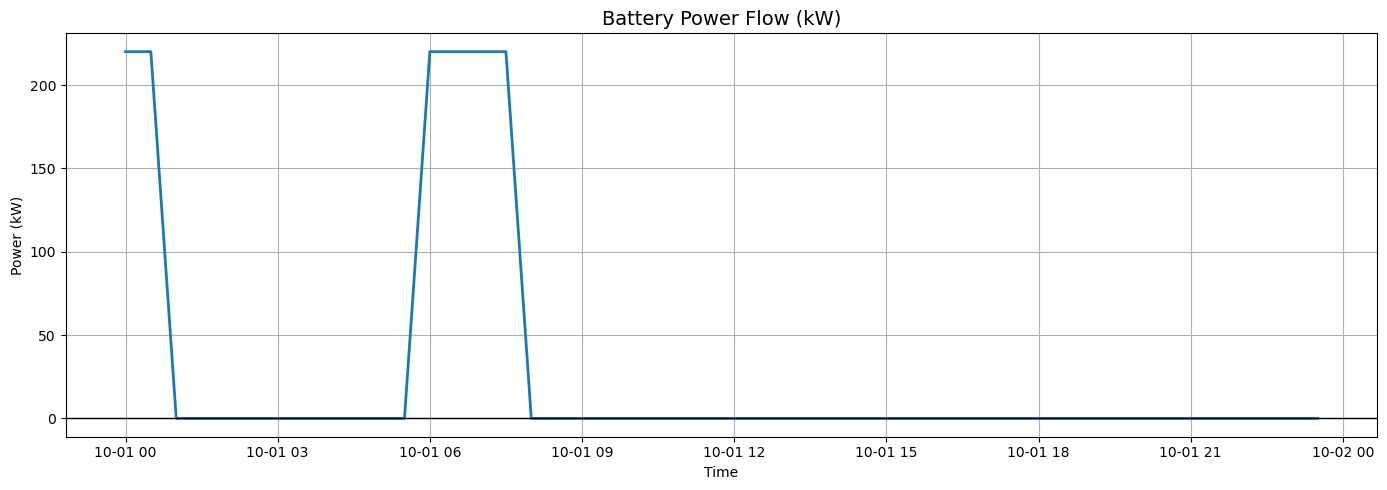

In [95]:
# Power Flow Plot
plt.figure(figsize=(14,5))
plt.plot(df_forecast["period_starting"], df_forecast["battery_power_kW"], label="Battery Power (kW)", linewidth=2)
plt.axhline(0, color="black", linewidth=1)
plt.title("Battery Power Flow (kW)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

<h2> Above chart shows the actual kW charged or discharged every 30 minutes.<br>
Positive = discharge (meeting demand) <br>
Zero = idle

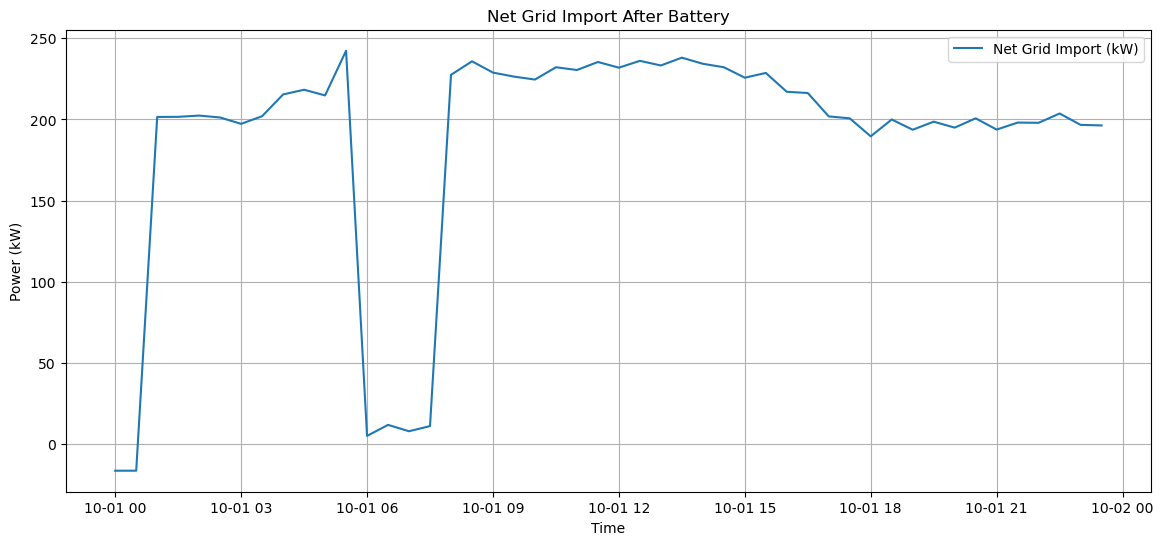

In [97]:
# Net Grid Import
plt.figure(figsize=(14,6))
plt.plot(df_forecast["period_starting"], df_forecast["net_grid_kW"], label="Net Grid Import (kW)")
plt.title("Net Grid Import After Battery")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.legend()
plt.show()

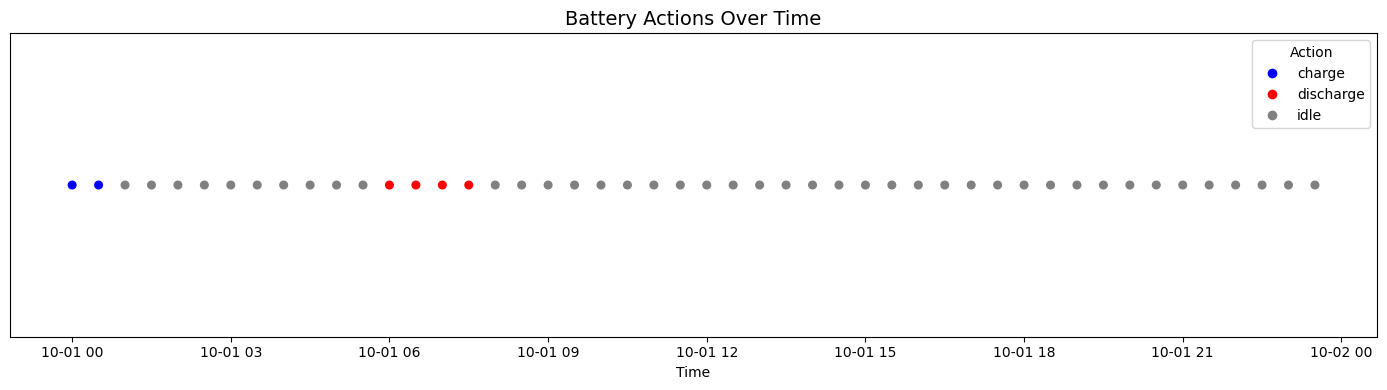

In [98]:
# Actions Timeline Plot
plt.figure(figsize=(14,4))
color_map = {"charge": "blue", "discharge": "red", "idle": "gray"}
colors = df_forecast["action"].map(color_map)

plt.scatter(df_forecast["period_starting"], [1]*len(df_forecast), c=colors, s=30)
plt.yticks([])
plt.title("Battery Actions Over Time", fontsize=14)
plt.xlabel("Time")

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=k,
                      markerfacecolor=v, markersize=8)
           for k, v in color_map.items()]
plt.legend(handles=handles, title="Action", loc="upper right")

plt.tight_layout()
plt.show()

<h2>Task 2 
<h4> Produce a plan for battery charging and discharging to minimize cost-to-supply the property over the next 24 hours. Compare the optimized cost-to-supply to the cost the customer would incur without a battery. Visualize the projected state of energy of the battery over the next 24 hours. The algorithm that produces this plan may be as simple or as complex as required. <br>
a.	You may assume that your forecast for site demand is perfect – i.e. there is no need to consider the uncertainty in your forecast, or that the battery plan may deviate from the one you have produced.


In [100]:
# Create a copy of forecast dataframe
df_plan = df_forecast.copy()
df_plan["planned_power_kW"] = 0
df_plan["planned_action"] = "idle"
df_plan["soc_kWh"] = 0

<h3> The total electricity cost over the next 24 hours is calculated as the sum of the grid import in each period multiplied by the electricity price and the duration of the period:
<h3> Cost = sum(Grid import_t * Price_t * DT) for t = 1 to 48
<h4>
Constraints: <br>

    - Battery can charge from the grid (MAX_POWER kW), up to CAPACITY kWh.
    - Battery can discharge to meet demand (MAX_POWER kW), but cannot export to grid.
    - Battery starts at SOC = 220 kWh.
    - Battery is perfectly efficient. 
<br>
Input: forecast_kW for next 48 periods, price_pence_per_kwh for each period.

In [102]:
# Initialize SOC
soc = SOC

# List to track SOC over time
soc_list = []

<h3> Since the I assuming forecast is perfect, the simplest optimization is:

Sort periods by price:

- Charge during the cheapest periods, up to full capacity.

- Discharge during the most expensive periods, up to available SOC.

- Ensure charging and discharging power limits (MAX_POWER) are not exceeded.
<br>
This is a simple greedy algorithm, which is often enough for 24-hour perfect-forecast problems.

In [104]:
cheap_order = df_plan.sort_values("price_pence_per_kwh").index

for idx in cheap_order:
    if soc >= CAPACITY:
        break
    available_capacity = CAPACITY - soc
    power = min(MAX_POWER, available_capacity / DT)
    df_plan.at[idx, "planned_power_kW"] = -power    # negative = charging
    df_plan.at[idx, "planned_action"] = "charge"
    soc += power * DT
    soc_list.append(soc)

expensive_order = df_plan.sort_values("price_pence_per_kwh", ascending=False).index

for idx in expensive_order:
    if soc <= 0:
        break
    power = min(MAX_POWER, soc / DT)
    # If the period was already charging, skip
    if df_plan.at[idx, "planned_action"] == "charge":
        continue
    df_plan.at[idx, "planned_power_kW"] = power      # positive = discharging
    df_plan.at[idx, "planned_action"] = "discharge"
    soc -= power * DT
    soc_list.append(soc)


# Fill remaining SOC for periods not modified

last_soc = SOC
for i in range(len(df_plan)):
    if df_plan.at[i, "planned_action"] in ["charge", "discharge"]:
        last_soc = soc_list.pop(0)
    df_plan.at[i, "soc_kWh"] = last_soc


In [105]:
# Calculate costs
df_plan["net_grid_kW"] = df_plan["forecast_kW"] - df_plan["planned_power_kW"].clip(lower=0)
df_plan["cost_with_battery"] = df_plan["net_grid_kW"] * df_plan["price_pence_per_kwh"] * DT
df_plan["cost_no_battery"] = df_plan["forecast_kW"] * df_plan["price_pence_per_kwh"] * DT

total_cost_with_battery = df_plan["cost_with_battery"].sum()
total_cost_no_battery = df_plan["cost_no_battery"].sum()
savings = total_cost_no_battery - total_cost_with_battery

print("Cost without battery (£):", total_cost_no_battery)
print("Cost with optimized battery (£):", total_cost_with_battery)
print("Total savings (£):", savings)

Cost without battery (£): 135169.77923516804
Cost with optimized battery (£): 116689.77923516804
Total savings (£): 18480.0


<h2> Impactful Results of Optimisation 
    
- Minimises cost-to-supply under perfect forecast. <br>

  Before Optimisation the Total savings were 18260.0 GBP and after optimisation ,it is 18480.0 GBP means we are saving ean xtra 220 because of the new stratergy of sorting periods by price. <br>

- Explicitly compares optimised battery cost vs no battery cost. 


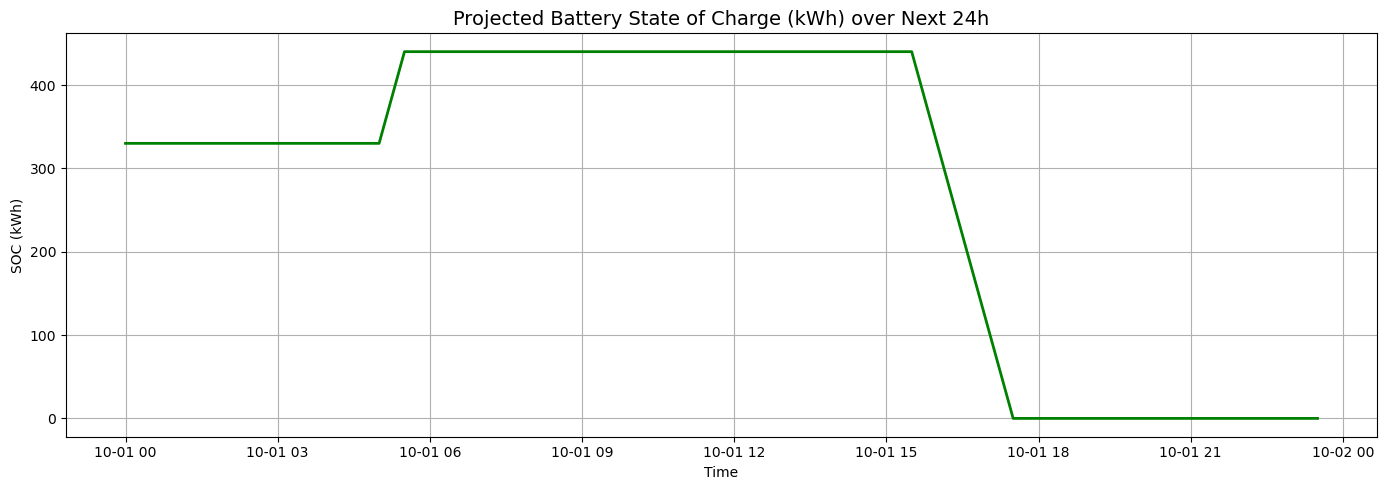

In [107]:
# Visualize SOC over time

plt.figure(figsize=(14,5))
plt.plot(df_plan["period_starting"], df_plan["soc_kWh"], linewidth=2, color="green")
plt.title("Projected Battery State of Charge (kWh) over Next 24h", fontsize=14)
plt.xlabel("Time")
plt.ylabel("SOC (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

<h3> State of charge period is for a long period of time, which is good for overall battery health and useful to reduce cost by maintaining battery while utilising its capacity 

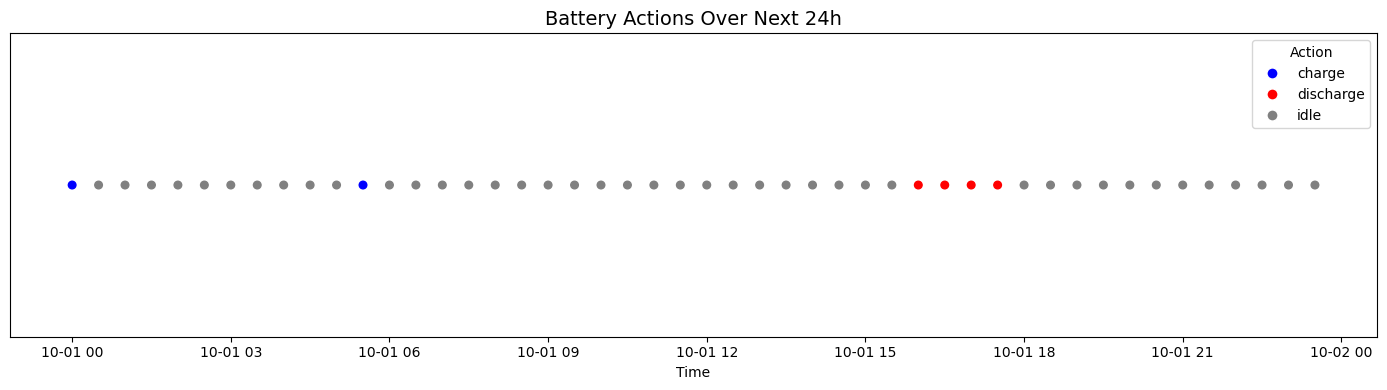

In [108]:

# Visualize Battery Actions

plt.figure(figsize=(14,4))
color_map = {"charge": "blue", "discharge": "red", "idle": "gray"}
colors = df_plan["planned_action"].map(color_map)

plt.scatter(df_plan["period_starting"], [1]*len(df_plan), c=colors, s=30)
plt.yticks([])
plt.title("Battery Actions Over Next 24h", fontsize=14)
plt.xlabel("Time")

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=k,
                      markerfacecolor=v, markersize=8)
           for k, v in color_map.items()]
plt.legend(handles=handles, title="Action", loc="upper right")
plt.tight_layout()
plt.show()


<h3>There is no difference in the number of actions for each type of action, but there is a significant difference in the pattern of actions. For example, for the action of "charge," there is a time gap that can be useful for various sites. Compared to the first methods, we can observe multiple long periods of idle states.

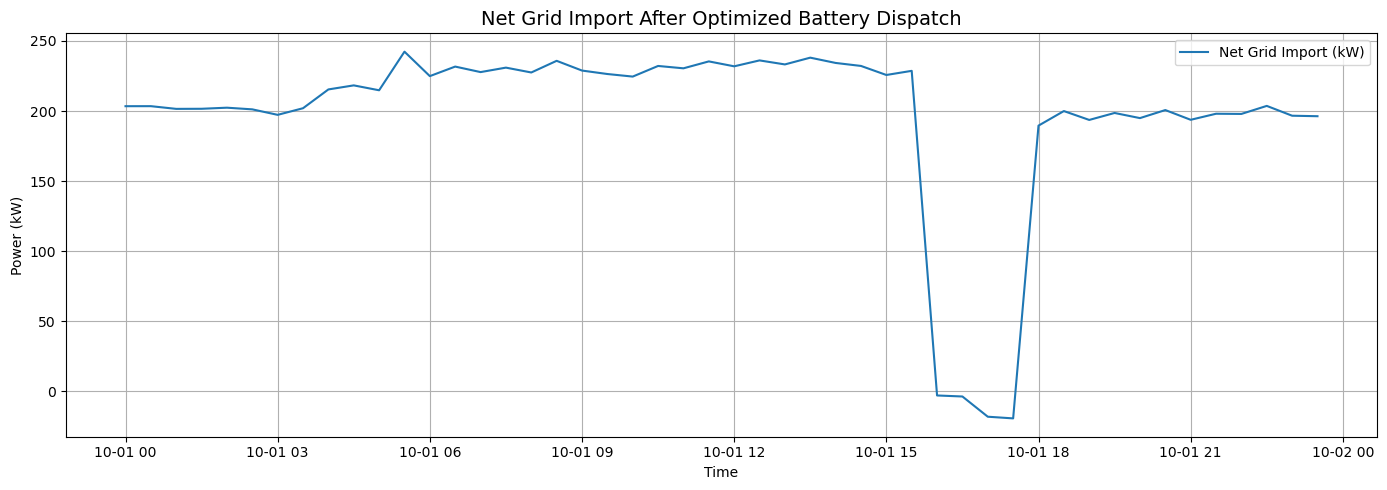

In [110]:
# ------------------------------
# Visualize Net Grid Import
# ------------------------------
plt.figure(figsize=(14,5))
plt.plot(df_plan["period_starting"], df_plan["net_grid_kW"], label="Net Grid Import (kW)")
plt.title("Net Grid Import After Optimized Battery Dispatch", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<h3>When we compare the previous Net Grid graph, it’s clear that the net grid import suddenly decreases primarily during the discharge action. Previously, before optimisation, this same decline was visible during both charging and discharging actions.

This submission is by:

    Shreyash Patil 
    Email: shreyashpatil2912@gmail.com 
    LinkedIn: https://www.linkedin.com/in/shreyashh/ 
    GitHub: https://github.com/ethan2912

In [141]:
%%bash
pip freeze > requirements.txt
